In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.preprocessing import normalize
import seaborn as sns

In [27]:
# plt.xkcd()
plt.rcdefaults()
plt.style.use("ggplot")

In [28]:
non_zero = pd.read_csv('data/hg19/matrix.mtx', sep=' ', skiprows=2,
                       names=('gene_id', 'cell_id', 'counts'))
shape = tuple(non_zero.iloc[0])[:2][::-1]
non_zero.drop(0, inplace=True)
genes = pd.read_csv('data/hg19/genes.tsv', sep='\t', names=('long', 'name'))

In [29]:
non_zero.gene_id -= 1
non_zero.cell_id -= 1

In [30]:
print(non_zero.max())

gene_id    32732
cell_id     2699
counts       419
dtype: int64


In [31]:
adata = sparse.csc_matrix((non_zero.counts, (non_zero.cell_id, non_zero.gene_id)),
                          dtype=np.int16, shape=shape)

In [32]:
adata.shape

(2700, 32738)

In [33]:
adata_norm = normalize(adata, norm='l1', axis=1)
total_count = np.array(adata_norm.sum(axis=0)).flatten()

In [34]:
total_count.shape

(32738,)

In [35]:
temp_ind = np.argpartition(total_count, -20)[-20:]
ind = temp_ind[np.argsort(total_count[temp_ind])]

In [36]:
ind

array([11887,  1989, 24087, 32022, 11447, 26912, 19420,   492,  5521,
       18998, 10709, 15745, 24673, 30933, 30970, 26013, 14247, 23794,
       13302, 19154])

<AxesSubplot:>

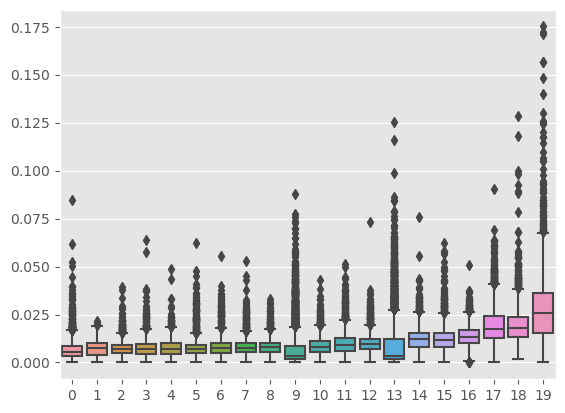

In [37]:
sns.boxplot(data=adata_norm[:,ind].toarray())

In [38]:
df = pd.DataFrame.sparse.from_spmatrix(adata, columns=genes.name)

In [39]:
# (np.array((adata != 0).sum(axis=1)).flatten() < 200).sum()
# (np.array((adata != 0).sum(axis=0)).flatten() < 3).sum()

In [40]:
cell_filter = (df != 0).sum(axis=1) >= 200
gene_filter = (df != 0).sum(axis=0) >= 3

In [41]:
df_filtered = df.loc[cell_filter, gene_filter]
mt_filter = df_filtered.columns.str.startswith('MT-')

In [42]:
gene_num_per_cell = (df_filtered != 0).sum(axis=1)
gene_counts_per_cell = df_filtered.sum(axis=1)
mt_pct = df_filtered.loc[:, mt_filter].sum(axis=1) / gene_counts_per_cell * 100

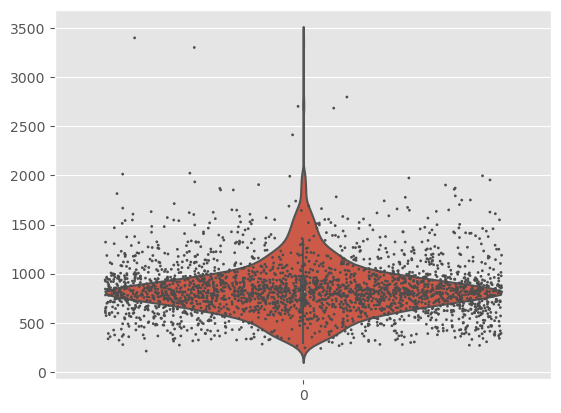

In [43]:
ax = sns.violinplot(data=gene_num_per_cell)
ax = sns.stripplot(data=gene_num_per_cell, jitter=0.4, size=2, color='.3')

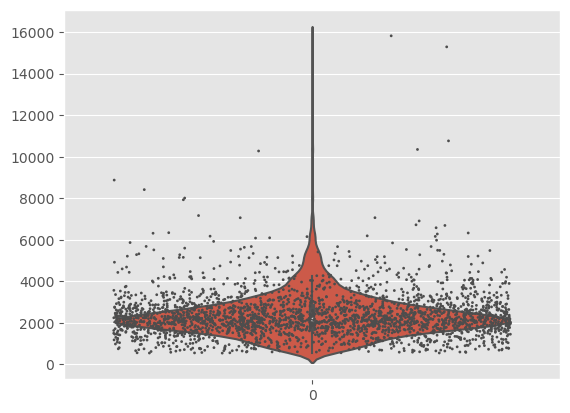

In [44]:
ax = sns.violinplot(data=gene_counts_per_cell)
ax = sns.stripplot(data=gene_counts_per_cell, jitter=0.4, size=2, color='.3')

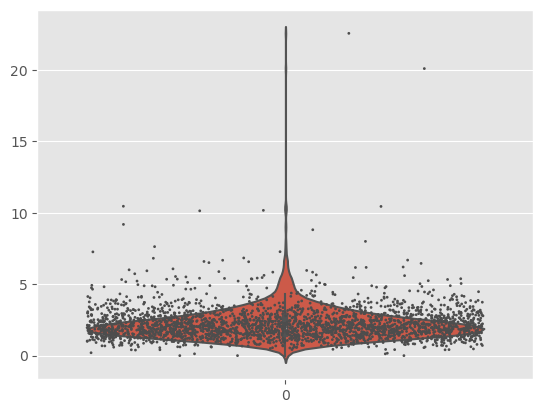

In [45]:
ax = sns.violinplot(data=mt_pct)
ax = sns.stripplot(data=mt_pct, jitter=0.4, size=2, color='.3')

In [46]:
temp_data = pd.DataFrame({'gene_counts_per_cell':gene_counts_per_cell,
                           'mt_pct':mt_pct, 
                           'gene_num_per_cell':gene_num_per_cell})

<AxesSubplot:xlabel='gene_counts_per_cell', ylabel='mt_pct'>

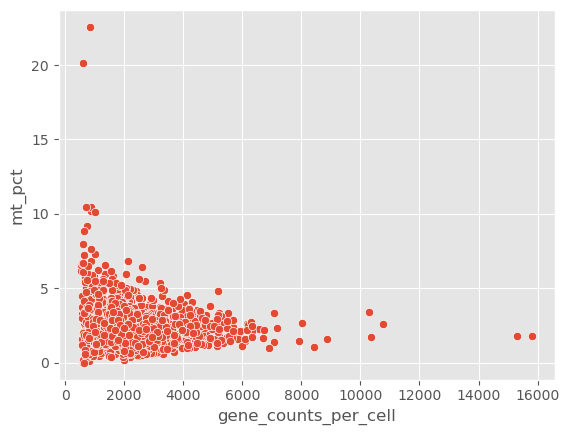

In [47]:
sns.scatterplot(data=temp_data, x='gene_counts_per_cell', y='mt_pct')

<AxesSubplot:xlabel='gene_counts_per_cell', ylabel='gene_num_per_cell'>

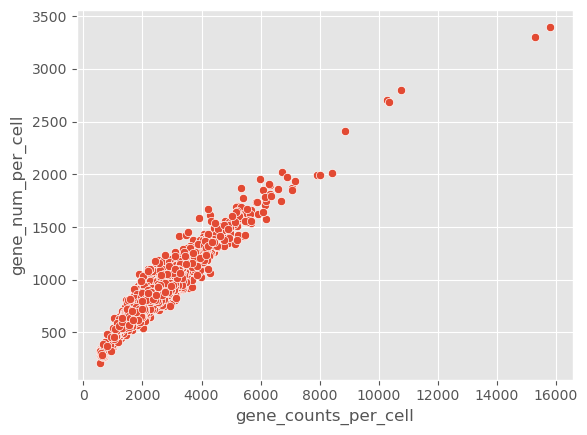

In [48]:
sns.scatterplot(data=temp_data, x='gene_counts_per_cell', y='gene_num_per_cell')

In [49]:
df_filtered_twice = df_filtered.loc[(gene_num_per_cell < 2500) & (mt_pct < 5)]

In [50]:
adata_filtered_twice = sparse.csr_matrix(df_filtered_twice)

In [51]:
adata_filtered_twice_norm = normalize(adata_filtered_twice, axis=1, norm='l1') * 1e4

In [52]:
adata_filtered_twice_norm_log1plus = adata_filtered_twice_norm.log1p()

In [53]:
def my_get_mean_var(X, axis=0):
    if isinstance(X, sparse.spmatrix):  # same as sparse.issparse()
        mean, var = my_sparse_mean_variance_axis(X, axis=axis)
        var *= X.shape[axis] / (X.shape[axis] - 1)
    else:
        mean = np.mean(X, axis=axis)
        mean_sq = np.var(X, axis=axis, ddof=1)  # a little overhead (mean counted twice, but it's ok.)
    return mean, var
'''
In standard statistical practice, ddof=1 provides an unbiased estimator of the variance
of a hypothetical infinite population. ddof=0 provides a maximum likelihood estimate of
the variance for normally distributed variables.
'''


def my_sparse_mean_variance_axis(mtx: sparse.spmatrix, axis: int):
    if isinstance(mtx, sparse.csr_matrix):
        ax_minor = 1
        shape = mtx.shape
    elif isinstance(mtx, sparse.csc_matrix):
        ax_minor = 0
        shape = mtx.shape[::-1]
    else:
        raise ValueError('This function only works on sparse csr and csc matrices')
    if axis == ax_minor:
        return sparse_mean_var_major_axis(
            mtx.data, mtx.indices, mtx.indptr, *shape, np.float64
        )
    else:
        return sparse_mean_var_minor_axis(
            mtx.data, mtx.indices, *shape, np.float64
        )
    

def my_sparse_mean_var_major_axis(data, indices, indptr, major_len, minor_len, dtype):
    means = np.zeros(major_len, dtype=dtype)
    varience = np.zeros_like(means, dtype=dtype)  # why use zeros_like?
    for startptr, endptr in zip(indptr[:-1], indptr[1:]):
        counts = endptr - startptr
        
        mean = sum(data[startptr:endptr])
        variance = sum((i-means[i]) ** 2 for i in data[startptr:endptr]) + mean ** 2 * (minor_len - counts)
        means[i] = mean / minor_len
        variances[i] = variance / minor_len
        
    return means, variances


def my_sparse_mean_var_minor_axis(data, indices, major_len, dtype):
    
    non_zero = indices.shape[0] # same as len(indices)?

    means = np.zeros(minor_len, dtype=dtype)
    variances = np.zeros_like(means, dtype=dtype)

    counts = np.zeros(minor_len, dtype=np.int64)
    
    for ind, num in zip(indices, data):
        means[ind] += num
    
    means /= major_len
    
    for ind, num, mean in zip(indices, data, means):
        variances[ind] += num - means
        counts[ind] += 1
        
    variances += [mean ** 2 * (major_len - count) for mean, count in zip(means, counts)]
    variances /= major_len
    
    return means, variances

In [ ]:
def highly_variable_genes_single_batch_seurat(
    adata  # log transformed, base e 
    layer,
    min_disp,
    max_disp,
    min_mean,
    max_mean,
    n_top_genes,
    n_bins,
    flavor='seurat'
):
    X = adata.layers[layer] if layer is not None else adata.X
    
    if flavor == 'seurat:
        # 如果不是以e为底的先变成以e为底
        X = np.expm1(X)
        # 然后还原
        
    mean, var = get_mean_var(X)
    mean[mean == 0] = 1e-12
    dispersion = var / mean
    if flavor == 'seurat':
        dispersion[dispersion == 0] = np.nan
        dispersion = np.log(dispersion)
        mean = np.log1p(mean)
    df = pd.DataFrame()
    df['dispersions'] = dispersion
    df['means'] = mean
    
    if flavor == 'seurat':
        df['mean_bin'] = pd.cut(df['means'], bins=n_bins)
        disp_grouped = df.groupby('mean_bin')['dispersions']
        disp_mean_bin = disp_grouped.mean()
        disp_std_bin = disp_grouped.std(ddof=1)
        one_gene_per_bin = disp_std_bin.isnull()
        one_gene_per_bin[df['mean_bin'].values]

In [67]:
mean, var = my_get_mean_var(adata)

NameError: name 'sparse_mean_variance_axis' is not defined

In [11]:
b = sparse.csr_matrix((3, 4), dtype=np.int8)

In [15]:
indptr = np.array([0, 2, 3, 6])
indices = np.array([0, 2, 2, 0, 1, 2])
data = np.array([1, 2, 3, 4, 5, 6])
b = sparse.csr_matrix((data, indices, indptr), shape=(3, 3))

In [20]:
len(b.indices)

6

In [21]:
sparse.issparse(b)

True

In [23]:
sparse.issparse([[0]])

False

In [65]:
print(adata_filtered_twice_norm[:,1:10])

  (11, 4)	4.187604690117253
  (16, 8)	2.181500872600349
  (20, 4)	3.0478512648582745
  (26, 7)	1.7618040873854828
  (29, 8)	4.844961240310077
  (33, 4)	5.681818181818182
  (41, 4)	2.931691586045148
  (42, 4)	4.591368227731864
  (49, 8)	2.801905295601009
  (52, 8)	2.6041666666666665
  (55, 4)	3.7993920972644375
  (56, 4)	4.3591979075850045
  (58, 4)	2.503755633450175
  (61, 4)	43.30566582461205
  (63, 8)	5.136106831022086
  (65, 8)	2.1659085986571367
  (70, 4)	3.996802557953637
  (91, 8)	4.330879168471199
  (99, 8)	3.2658393207054215
  (102, 3)	4.035512510088781
  (107, 4)	1.6252234682268811
  (110, 6)	6.514657980456026
  (116, 4)	3.1938677738741617
  (122, 4)	5.640157924421884
  (131, 4)	2.969121140142518
  :	:
  (2556, 4)	3.3068783068783065
  (2557, 8)	3.8095238095238098
  (2560, 3)	3.673769287288758
  (2562, 4)	6.071645415907711
  (2563, 4)	5.434782608695652
  (2565, 4)	13.175230566534914
  (2567, 4)	6.447453255963894
  (2571, 4)	7.280669821623589
  (2571, 8)	7.280669821623589
  (258

In [64]:
print(np.expm1(adata_filtered_twice_norm_log1plus)[:,1:10])

  (11, 4)	4.1876046901172534
  (16, 8)	2.181500872600349
  (20, 4)	3.047851264858274
  (26, 7)	1.7618040873854828
  (29, 8)	4.844961240310077
  (33, 4)	5.681818181818182
  (41, 4)	2.9316915860451473
  (42, 4)	4.591368227731864
  (49, 8)	2.801905295601009
  (52, 8)	2.604166666666666
  (55, 4)	3.799392097264437
  (56, 4)	4.3591979075850045
  (58, 4)	2.503755633450175
  (61, 4)	43.30566582461205
  (63, 8)	5.136106831022086
  (65, 8)	2.1659085986571367
  (70, 4)	3.9968025579536364
  (91, 8)	4.330879168471199
  (99, 8)	3.265839320705421
  (102, 3)	4.035512510088781
  (107, 4)	1.6252234682268811
  (110, 6)	6.514657980456027
  (116, 4)	3.193867773874161
  (122, 4)	5.640157924421883
  (131, 4)	2.9691211401425175
  :	:
  (2556, 4)	3.3068783068783065
  (2557, 8)	3.8095238095238093
  (2560, 3)	3.673769287288758
  (2562, 4)	6.071645415907711
  (2563, 4)	5.434782608695652
  (2565, 4)	13.175230566534914
  (2567, 4)	6.447453255963893
  (2571, 4)	7.28066982162359
  (2571, 8)	7.28066982162359
  (2586, 